# <h1><center>MPC Planner  <a href="https://colab.research.google.com/github/patsyuk03/thesis_2025/blob/colab_demo/sampling_based_planner/mpc_planning.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

In [2]:
#@title Install MuJoCo and MJX
!pip install mujoco
!pip install mujoco_mjx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 47.3 MB/s eta 0:00:00


In [3]:
#@title Check if MuJoCo installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [28]:
#@title Import packages for plotting and creating graphics
import time
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

Installing mediapy:


In [6]:
#@title Clone GitHUb repository with MPC Planner
import os
!git clone -b colab_demo https://github.com/patsyuk03/thesis_2025.git
os.chdir('thesis_2025/sampling_based_planner')

fatal: destination path 'thesis_2025' already exists and is not an empty directory.


In [26]:
#@title Import MuJoCo, JAX, MPC Planner
from mjx_planner import cem_planner
import mujoco
import jax.numpy as jnp
from quat_math import quaternion_distance, rotation_quaternion, quaternion_multiply

In [18]:
#@title Initialize CEM Planner
start_time = time.time()
cem =  cem_planner(
    num_dof=6,
    num_batch=4000,
    num_steps=10,
    maxiter_cem=2,
    w_pos=5,
    w_rot=1.5,
    w_col=15,
    num_elite=0.05,
    timestep=0.05
    )
print(f"Initialized CEM Planner: {round(time.time()-start_time, 2)}s")


 Default backend: gpu
 Model path: /content/thesis_2025/sampling_based_planner/ur5e_hande_mjx/scene.xml 
 Timestep: 0.05 
 CEM Iter: 2 
 Number of batches: 4000 
 Number of steps per trajectory: 10 
 Time per trajectory: 0.5
Initialized CEM Planner: 29.84s


In [19]:
#@title Initialize Model and Data
model = cem.model
data = cem.data
data.qpos[:6] = jnp.array([1.5, -1.8, 1.75, -1.25, -1.6, 0])
mujoco.mj_forward(model, data)
renderer = mujoco.Renderer(model)

xi_mean = jnp.zeros(cem.nvar)
target_pos = model.body(name="target").pos
target_rot = model.body(name="target").quat

In [20]:
#@title Perform first compute
start_time = time.time()
_ = cem.compute_cem(xi_mean, data.qpos[:6], data.qvel[:6], data.qacc[:6], target_pos, target_rot)
print(f"Compute CEM: {round(time.time()-start_time, 2)}s")

Compute CEM: 39.54s


In [21]:
#@title Initialize target positions
init_position = data.site_xpos[model.site(name="tcp").id].copy()
init_rotation = data.xquat[model.body(name="hande").id].copy()

target_positions = [
    [-0.3, 0.3, 0.8],
    [-0.2, -0.4, 1.0],
    [-0.3, -0.1, 0.8],
    init_position
]

target_rotations = [
    rotation_quaternion(-135, np.array([1,0,0])),
    quaternion_multiply(rotation_quaternion(90, np.array([0,0,1])),rotation_quaternion(135, np.array([1,0,0]))),
    quaternion_multiply(rotation_quaternion(180, np.array([0,0,1])),rotation_quaternion(-90, np.array([0,1,0]))),
    init_rotation
]

target_idx = -1

In [22]:
#@title Set visualization Options

camera = mujoco.MjvCamera()
camera.lookat[:] = [0.0, 0.0, 0.0]
camera.distance = 3.0

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.sitegroup[:] = False
scene_option.sitegroup[1] = True

In [29]:
#@title Run MPC Planner

framerate = 30

cost_list = list()
cost_g_list = list()
cost_r_list = list()
cost_c_list = list()
thetadot_list = list()
theta_list = list()
frames = list()

prev_target_idx = target_idx
while target_idx == prev_target_idx and target_idx<len(target_positions):
    start_time = time.time()
    target_pos = model.body(name="target").pos
    target_rot = model.body(name="target").quat

    cost, best_cost_g, best_cost_c, best_vels, best_traj, xi_mean = cem.compute_cem(xi_mean, data.qpos[:6], data.qvel[:6], data.qacc[:6], target_pos, target_rot)
    thetadot = np.mean(best_vels[1:5], axis=0)
    # thetadot = best_vels[1]

    data.qvel[:6] = thetadot
    mujoco.mj_step(model, data)

    cost_g = np.linalg.norm(data.site_xpos[cem.tcp_id] - target_pos)
    cost_r = quaternion_distance(data.xquat[cem.hande_id], target_rot)
    cost = np.round(cost, 2)
    print(f'Step Time: {"%.0f"%((time.time() - start_time)*1000)}ms | Cost g: {"%.2f"%(float(cost_g))} | Cost r: {"%.2f"%(float(cost_r))} | Cost c: {"%.2f"%(float(best_cost_c))} | Cost: {cost}')

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option, camera=camera)
        pixels = renderer.render()
        frames.append(pixels)

    if cost_g<0.03 and cost_r<0.3:
        target_idx += 1
        if target_idx<len(target_positions):
            model.body(name="target").pos = target_positions[target_idx]
            model.body(name="target").quat = target_rotations[target_idx]

    cost_g_list.append(cost_g)
    cost_r_list.append(cost_r)
    cost_c_list.append(best_cost_c)
    thetadot_list.append(thetadot)
    theta_list.append(data.qpos[:6].copy())
    cost_list.append(cost[-1])

    time_until_next_step = model.opt.timestep - (time.time() - start_time)
    if time_until_next_step > 0:
        time.sleep(time_until_next_step)

Step Time: 329ms | Cost g: 0.36 | Cost r: 1.72 | Cost c: 0.00 | Cost: [43.54 43.39]
Step Time: 233ms | Cost g: 0.36 | Cost r: 1.71 | Cost c: 0.00 | Cost: [42.92     42.829998]
Step Time: 230ms | Cost g: 0.36 | Cost r: 1.70 | Cost c: 0.00 | Cost: [42.09 42.07]
Step Time: 229ms | Cost g: 0.35 | Cost r: 1.69 | Cost c: 0.01 | Cost: [41.309998 41.3     ]
Step Time: 231ms | Cost g: 0.35 | Cost r: 1.68 | Cost c: 0.01 | Cost: [40.62 40.59]
Step Time: 232ms | Cost g: 0.34 | Cost r: 1.66 | Cost c: 0.01 | Cost: [39.93     39.899998]
Step Time: 231ms | Cost g: 0.34 | Cost r: 1.64 | Cost c: 0.01 | Cost: [39.21 39.18]
Step Time: 230ms | Cost g: 0.33 | Cost r: 1.62 | Cost c: 0.01 | Cost: [38.469997 38.46    ]
Step Time: 229ms | Cost g: 0.33 | Cost r: 1.60 | Cost c: 0.01 | Cost: [37.79 37.76]
Step Time: 232ms | Cost g: 0.32 | Cost r: 1.58 | Cost c: 0.01 | Cost: [37.07 37.04]
Step Time: 231ms | Cost g: 0.31 | Cost r: 1.55 | Cost c: 0.01 | Cost: [36.329998 36.3     ]
Step Time: 231ms | Cost g: 0.31 | Co

In [30]:
media.show_video(frames, fps=framerate)

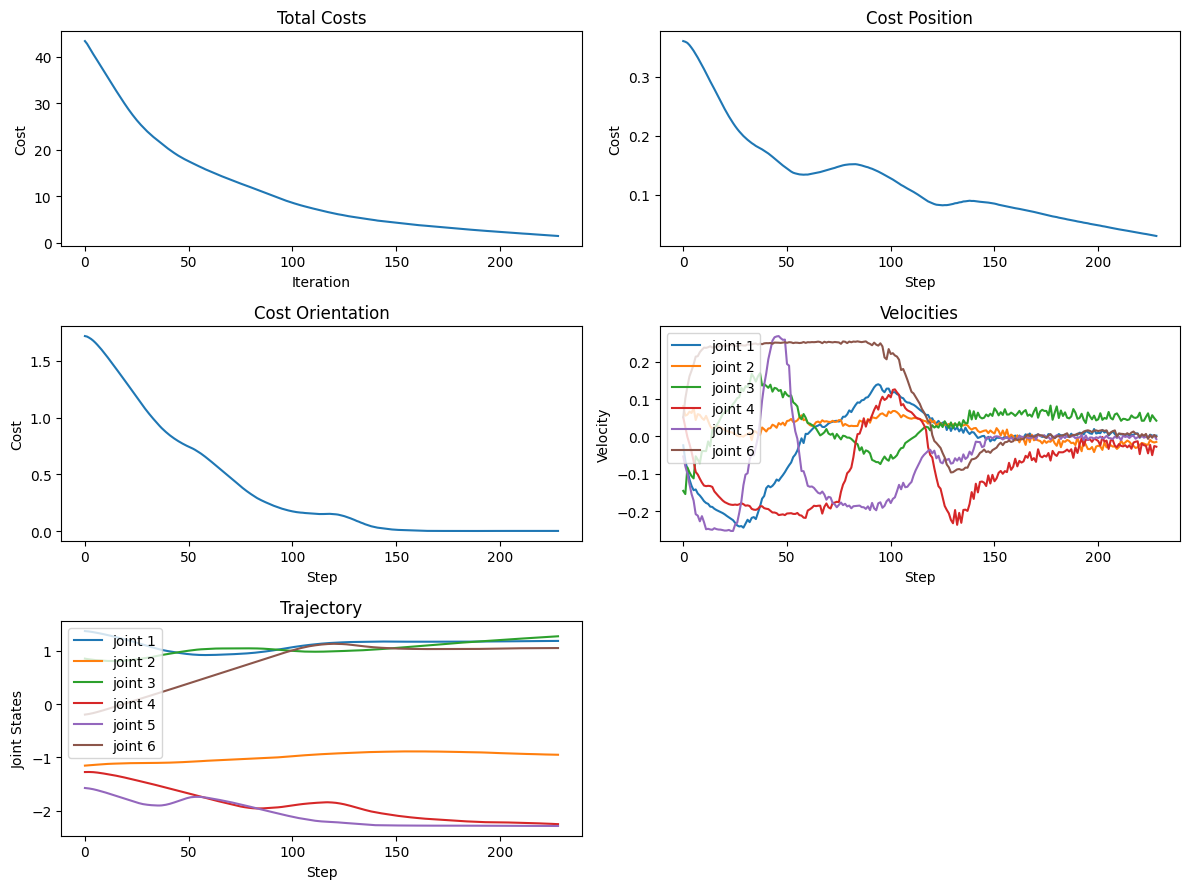

In [34]:
#@title Plot Cost and Trajectory


fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs = axs.flatten()  # Flatten to easily index

# Total Costs
axs[0].plot(cost_list)
axs[0].set_title("Total Costs")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Cost")

# Cost Position
axs[1].plot(cost_g_list)
axs[1].set_title("Cost Position")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Cost")

# Cost Orientation
axs[2].plot(cost_r_list)
axs[2].set_title("Cost Orientation")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Cost")

# Velocities
axs[3].plot(thetadot_list)
axs[3].set_title("Velocities")
axs[3].set_xlabel("Step")
axs[3].set_ylabel("Velocity")
axs[3].legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')

# Trajectory
axs[4].plot(theta_list)
axs[4].set_title("Trajectory")
axs[4].set_xlabel("Step")
axs[4].set_ylabel("Joint States")
axs[4].legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')

# Hide unused subplot
fig.delaxes(axs[5])

plt.tight_layout()
plt.show()
